In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sn
import keras
from sklearn.metrics import precision_score, recall_score, f1_score

2023-03-30 17:18:34.943394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 17:18:35.135864: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-30 17:18:35.135889: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-30 17:18:35.161084: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-30 17:18:35.722126: W tensorflow/stream_executor/platform/de

# Import Data

In [15]:
df = pd.read_csv("data/data_right.csv", index_col=0)
df.tail()

,index,middle,ring,pinky,label
159935,"[0.20588235294117624, 0.20588235294117624, 0.2...","[0.902254409463127, 0.902254409463127, 0.90208...","[0.9900052169121742, 0.9900052169121742, 0.990...","[0.9963689704020832, 0.9963689704020832, 0.996...",4-4
159936,"[0.20517241379310305, 0.20517241379310305, 0.2...","[0.9019139943862396, 0.9019139943862396, 0.901...","[0.9896662412047679, 0.9896662412047679, 0.989...","[0.99636890657134, 0.99636890657134, 0.9963689...",4-4
159937,"[0.20309810671256565, 0.20309810671256565, 0.2...","[0.9015749535299048, 0.9015749535299048, 0.901...","[0.9893274045996283, 0.9893274045996283, 0.989...","[0.9963688975135385, 0.9963688975135385, 0.996...",4-4
159938,"[0.2013651877133101, 0.20307167235494875, 0.20...","[0.9007786395940026, 0.9007786395940026, 0.900...","[0.9884862585194406, 0.9886555782470959, 0.988...","[0.996368908937689, 0.996368908937689, 0.99636...",4-4
159939,"[0.2033898305084746, 0.2033898305084746, 0.205...","[0.9001348366181828, 0.9003040996069657, 0.900...","[0.9881515907852081, 0.9881515907852081, 0.988...","[0.9960072349640712, 0.9960072349640712, 0.996...",4-4


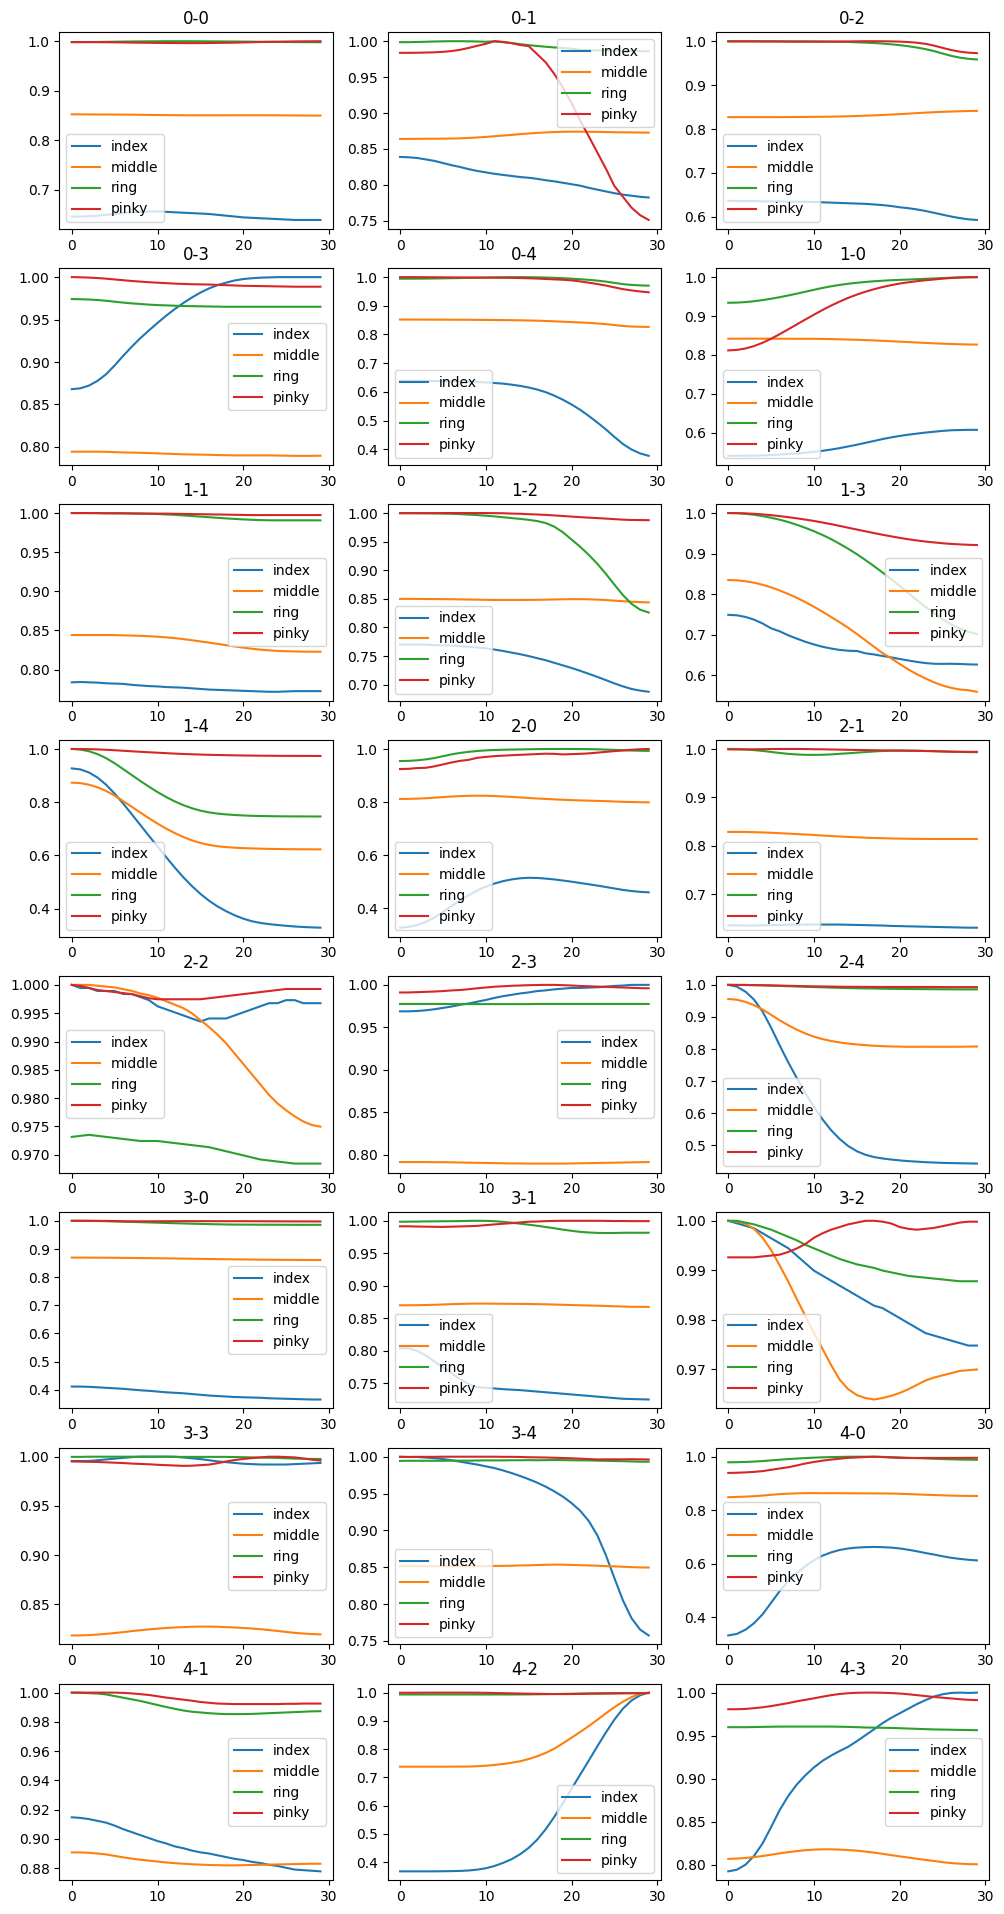

In [12]:
# visualize data
df_reduced = df.groupby('label', group_keys=False).apply(lambda df: df.sample(1))
fig, ax = plt.subplots(8,3)
fig.set_size_inches((12,24))
for i in range(24):
    row = df_reduced.iloc[i,:]
    r,c = i//3, i%3
    label = row["label"]
    ax[r,c].set_title(label)
    ax[r,c].plot(np.array(json.loads(row["index"])), label="index")
    ax[r,c].plot(np.array(json.loads(row["middle"])), label="middle")
    ax[r,c].plot(np.array(json.loads(row["ring"])), label="ring")
    ax[r,c].plot(np.array(json.loads(row["pinky"])), label="pinky")
    ax[r,c].legend()
plt.show()

# Data Processing

In [16]:
# data processing
## X
n_steps = len(json.loads(df.iloc[0,0]))
n_features = 4
X = np.empty((df.shape[0], n_steps, n_features))
for i in range(X.shape[0]):    
    x = np.empty((n_steps, n_features))
    for j in range(n_features):
        arr = np.array(json.loads(df.iloc[i,j]))
        x[:,j] = arr
    X[i] = x
    
## y
labels = df["label"].to_numpy()
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
n_classes = len(np.unique(y_encoded))
y = to_categorical(y_encoded)

## split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Model Training

In [5]:
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           68096     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 batch_normalization (BatchN  (None, 30, 128)          512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 25)                3

2023-03-30 02:01:14.908648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-30 02:01:14.908853: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-30 02:01:14.908910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-30 02:01:14.909131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-30 02:01:14.909188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [6]:
n_epochs = 100
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=128)

Epoch 1/100
8/8 [==============================] - 2s 108ms/step - loss: 2.1714 - accuracy: 0.3582 - val_loss: 2.7550 - val_accuracy: 0.4071
Epoch 2/100
8/8 [==============================] - 1s 65ms/step - loss: 1.1021 - accuracy: 0.6857 - val_loss: 2.0826 - val_accuracy: 0.5190
Epoch 3/100
8/8 [==============================] - 1s 68ms/step - loss: 0.7153 - accuracy: 0.8082 - val_loss: 1.4455 - val_accuracy: 0.6024
Epoch 4/100
8/8 [==============================] - 0s 64ms/step - loss: 0.5416 - accuracy: 0.8347 - val_loss: 1.1113 - val_accuracy: 0.7214
Epoch 5/100
8/8 [==============================] - 0s 63ms/step - loss: 0.4222 - accuracy: 0.8612 - val_loss: 1.0644 - val_accuracy: 0.7405
Epoch 6/100
8/8 [==============================] - 1s 68ms/step - loss: 0.3242 - accuracy: 0.9163 - val_loss: 1.0057 - val_accuracy: 0.7786
Epoch 7/100
8/8 [==============================] - 1s 65ms/step - loss: 0.2717 - accuracy: 0.9163 - val_loss: 0.9019 - val_accuracy: 0.8071
Epoch 8/100
8/8 [==

# Model Evaluation

Train accuracy: 0.9938775300979614
Validation accuracy: 0.9166666865348816
Test accuracy: 0.8899999856948853


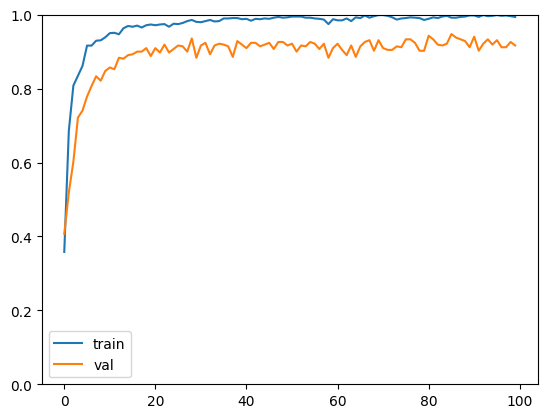

In [7]:
print("Train accuracy:", history.history["accuracy"][-1])
print("Validation accuracy:", history.history["val_accuracy"][-1])
print("Test accuracy:", model.evaluate(X_test, y_test, verbose=0)[1])
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.ylim((0,1))
plt.show()

In [2]:
model = keras.models.load_model("models/lstm/")

2023-03-30 17:18:41.605386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-30 17:18:41.605748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-30 17:18:41.605808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-30 17:18:41.605845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-30 17:18:41.605880: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Precision: 0.8533916241371265
Recall: 0.8096048309759603
F1-score: 0.79957427457599


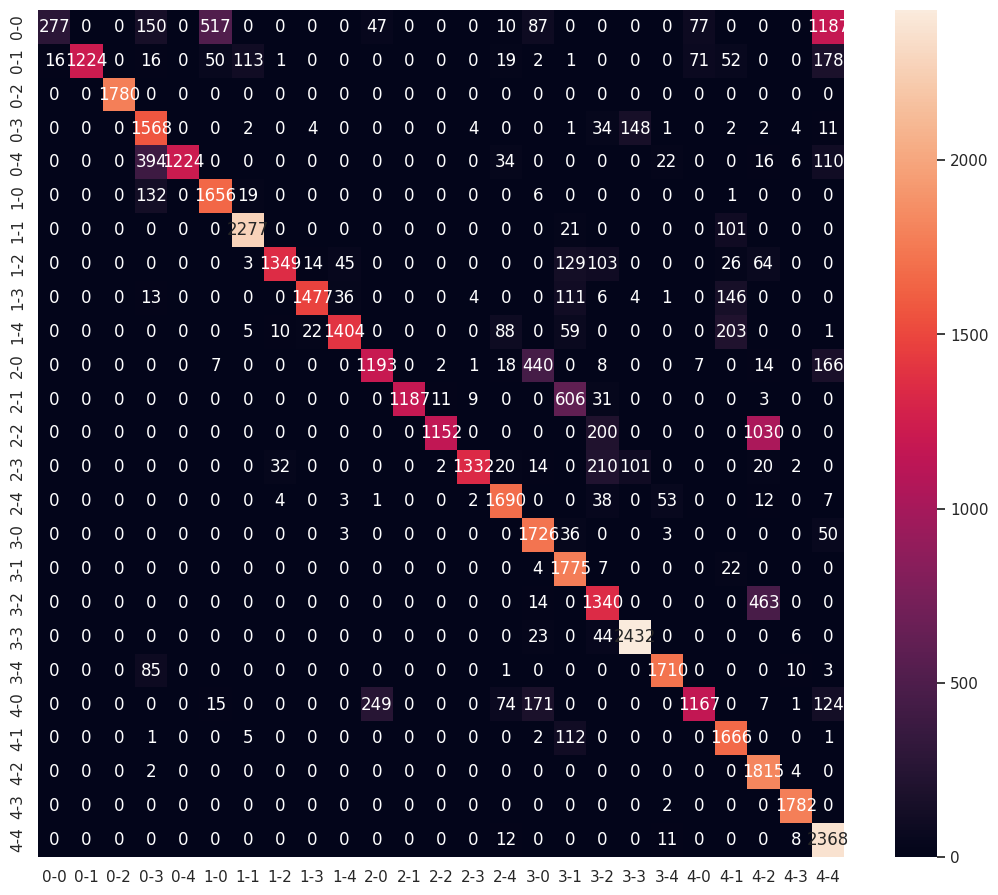

In [24]:
y_pred = model.predict(X_test, verbose=0)
y_pred_rd = np.argmax(y_pred, axis=1)
y_test_rd = np.argmax(y_test, axis=1)

print("Precision:", precision_score(y_test_rd, y_pred_rd, average="macro"))
print("Recall:", recall_score(y_test_rd, y_pred_rd, average="macro"))
print("F1-score:", f1_score(y_test_rd, y_pred_rd, average="macro"))

cm = confusion_matrix(y_test_rd, y_pred_rd)
df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
plt.figure(figsize=(13,11))
sn.set(font_scale=1) # for label size
ticklabels = np.unique(labels)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt="d",
           xticklabels=ticklabels, yticklabels=ticklabels) # font size
plt.show()

In [19]:
import time 

start = time.time()
y_prediction = model.predict(X_test) 
end = time.time()

print("Inference time: %f ms" % ((end - start)/X_test.shape[0] * 1000))

1500/1500 [==============================] - 15s 10ms/step
Inference time: 0.310851 ms


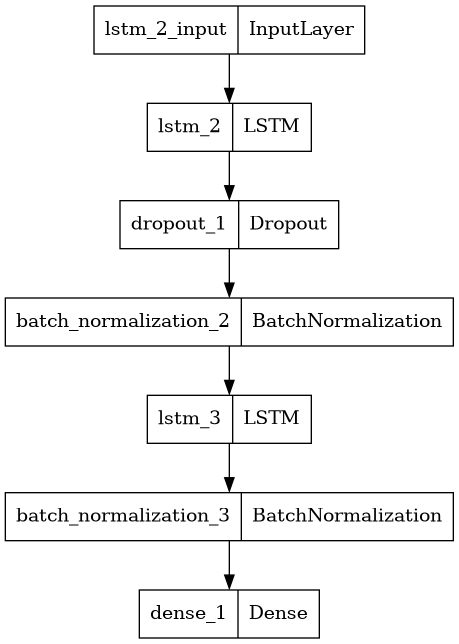

In [3]:
keras.utils.plot_model(model)